필사 예제: https://www.kaggle.com/code/akhiljethwa/playground-s4e1-eda-modeling-xgboost

## Table of Contents
- [1. 데이터 탐색 및 설명](#ch1)

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
rc = {
    "axes.facecolor": "#F8F8F8",
    "figure.facecolor": "#F8F8F8",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7" + "30",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4,
}

sns.set(rc=rc)
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

### 1. 데이터 탐색 및 설명

- Customer ID: A unique identifier for each customer- Surname: The customer's surname or last nam
- Credit Score: A numerical value representing the customer's credit score
- Geography: The country where the customer resides
- Gender: The customer's gender
- Age: The customer's age.
- Tenure: The number of years the customer has been with the bank
- Balance: The customer's account balance
- NumOfProducts: The number of bank products the customer uses (e.g., savings account, credit card)
- HasCrCard: Whether the customer has a credit card
- IsActiveMember: Whether the customer is an active member
- EstimatedSalary: The estimated salary of the customer
- Exited: Whether the customer has churned (Target Variable)et Variable)

In [4]:
train_data = pd.read_csv('data/train.csv')
train_data.shape

(165034, 14)

In [5]:
train_data.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


### 1.1 Train Data 해설
- CustomerId: 문제가 있는 값임.
- Balance와 Salary의 표준편차가 지나치게 큼.
- 표준화 작업이 필요함

In [6]:
train_data.describe().T.style.background_gradient()
#T: transpose, 행과 열 바꾸기. 행 방향으로 통계정보 확인
#style.background_gradient(): describe 메서드의 결과에 대해 스타일 적용. 높은 통계값은 진하게, 낮으면 연하게 표시

,count,mean,std,min,25%,50%,75%,max
id,165034.000000,82516.500000,47641.356500,0.000000,41258.250000,82516.500000,123774.750000,165033.000000
CustomerId,165034.000000,15692005.019026,71397.816791,15565701.000000,15633141.000000,15690169.000000,15756824.000000,15815690.000000
CreditScore,165034.000000,656.454373,80.103340,350.000000,597.000000,659.000000,710.000000,850.000000
Age,165034.000000,38.125888,8.867205,18.000000,32.000000,37.000000,42.000000,92.000000
Tenure,165034.000000,5.020353,2.806159,0.000000,3.000000,5.000000,7.000000,10.000000
Balance,165034.000000,55478.086689,62817.663278,0.000000,0.000000,0.000000,119939.517500,250898.090000
NumOfProducts,165034.000000,1.554455,0.547154,1.000000,1.000000,2.000000,2.000000,4.000000
HasCrCard,165034.000000,0.753954,0.430707,0.000000,1.000000,1.000000,1.000000,1.000000
IsActiveMember,165034.000000,0.497770,0.499997,0.000000,0.000000,0.000000,1.000000,1.000000
EstimatedSalary,165034.000000,112574.822734,50292.865585,11.580000,74637.570000,117948.000000,155152.467500,199992.480000


### 2. 탐색적 데이터 분석(EDA) - 필사

### 2.1 결측치(Null Values)
- displot: 분포를 시각화
- isnull(): 데이터를 결측값 여부로 변환
- melt(): 데이터 프레임 재구성

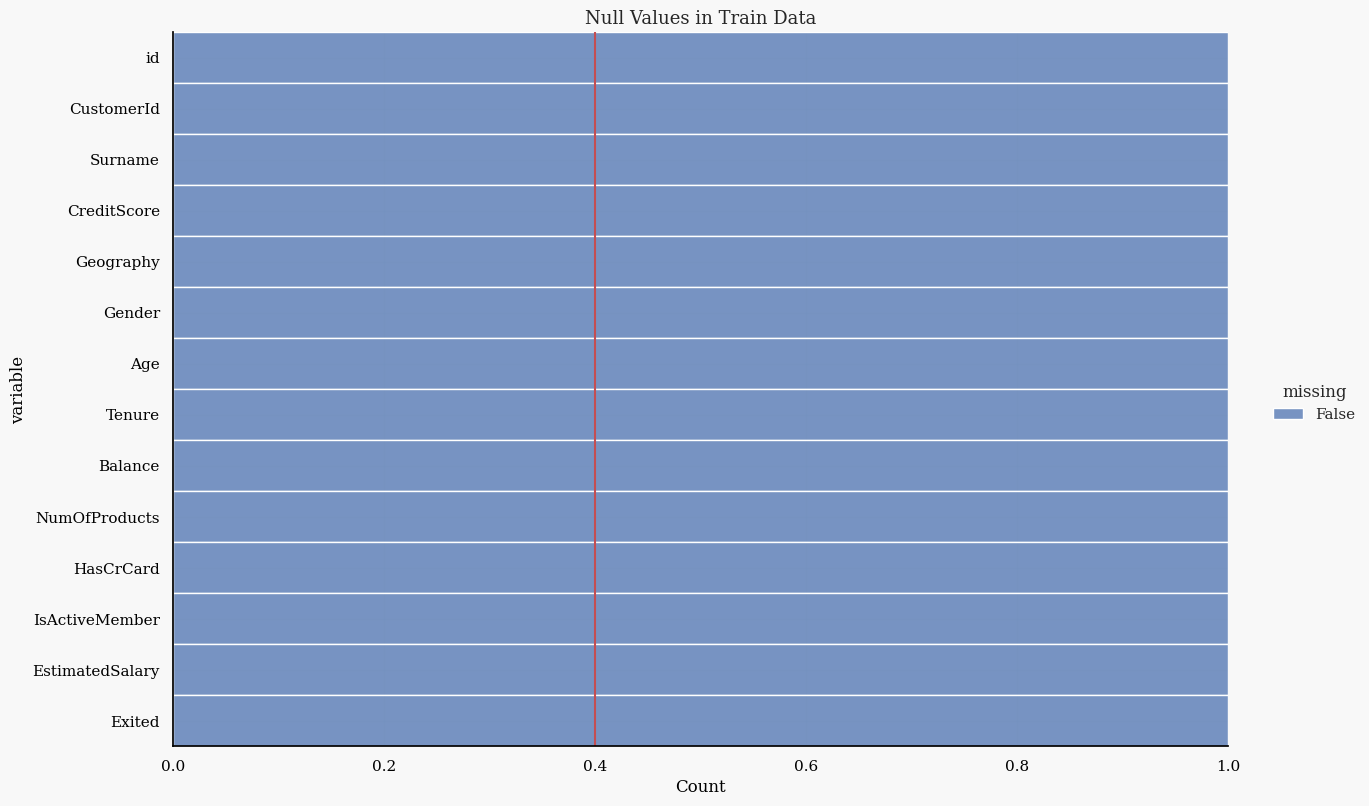

In [7]:
sns.displot(data = train_data.isnull().melt(value_name = 'missing'), #결측값 여부에 대한 정보를 variable열, 결측값 여부를 missing으로
            y = 'variable',
            hue = 'missing', #missing열의 값을 기준으로 색을 지정한다.
            multiple = 'fill',
            height = 8,
            aspect = 1.6 #가로세로 비율
           )

#임계치(threshold value) 지정
plt.axvline(0.4, color = 'r') #0.4에 빨간 선을 그린다.
plt.title('Null Values in Train Data', fontsize=13) #제목
plt.show()

### 2.1 목적변수 분석(Target Variable)
- 원본 데이터와 대회 데이터의 Exited와 Not Exited 클래스의 분포가 거의 동일하다.
- 데이터의 80%가 Not Exited이고 20%가 Exited이다.
- 이탈한 가입자(Exited)가 분석대상인 변수이다.

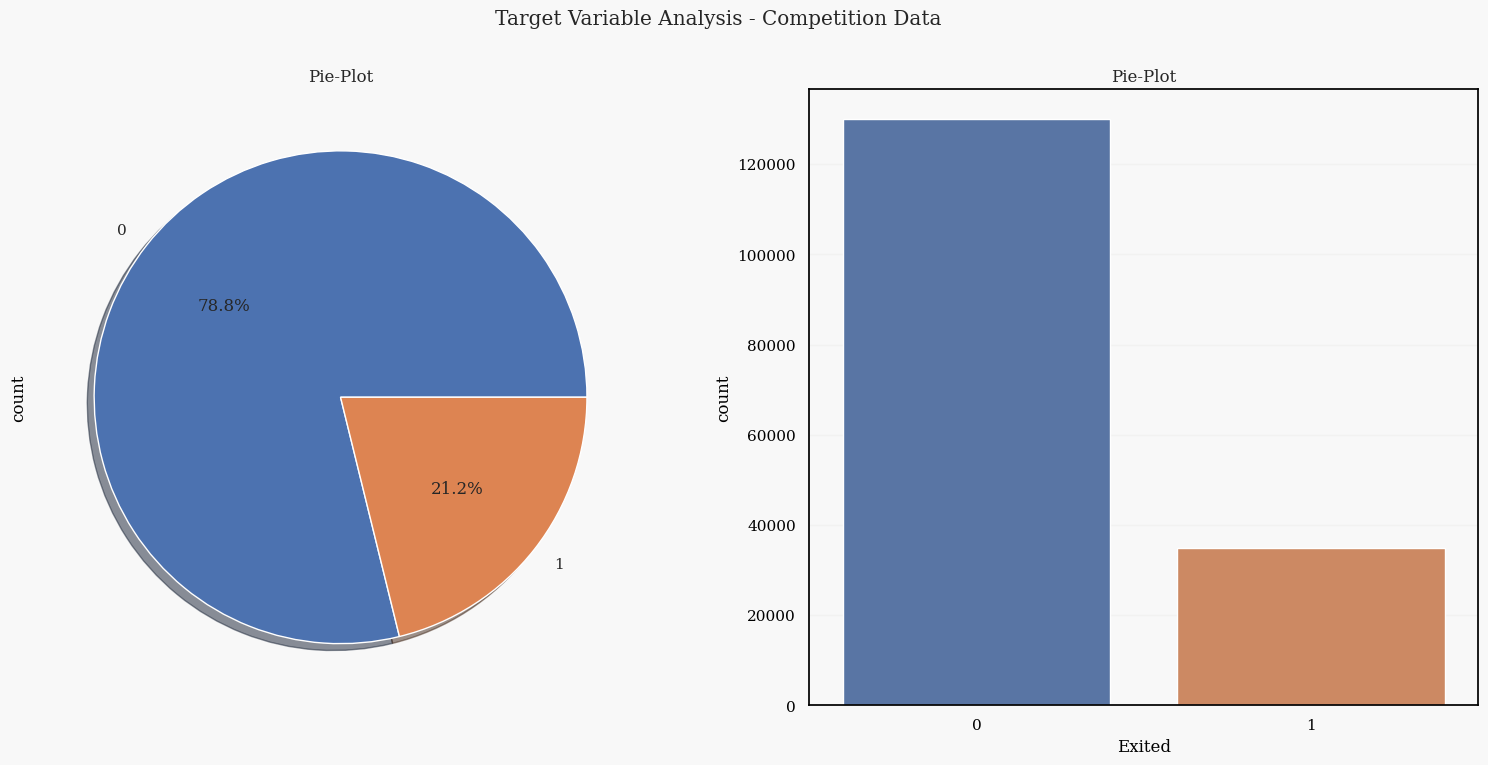

In [8]:
#너비 19, 높이 8의 두 개의 서브플롯을 가진 그림 생성
f, ax = plt.subplots(1, 2, figsize = (19,8))

#ax[0] 위치에 원형 차트 생성
train_data['Exited'].value_counts().plot.pie(autopct = '%1.1f%%', ax = ax[0], shadow =True)
ax[0].set_title('Pie-Plot')

#ax[1] 위치에 countplot 생성
sns.countplot(x = 'Exited', data = train_data, ax =ax[1],
             hue = 'Exited', legend =False
             )
ax[1].set_title('Pie-Plot')

plt.suptitle('Target Variable Analysis - Competition Data')
plt.show()

### 2.2 범주형 변수 분석(Categorical Variable)- 연속형 변수와 범주형 변주를 구분하기 위한 임계값으로 12를 설정
- 거의 균등하게 분포: IsActiveMember, Tenure and Gender
- 균등하게 분포되어 있지 않음: HasCrCard, NumOfProducts, Gender
- Tenure은 클래스가 11개로 연속형 변수에 포함되기 직전이었음이다.

In [9]:
#연속형 변수와 범주형 변수 구분

#각 열의 고유값의 수를 계산하여 변수에 저장
unique_counts = train_data.nunique()

#연속형 변수와 범주형 변수의 임계값 설정 - 12
threshold = 12
continuous_vars = unique_counts[unique_counts > threshold].index.tolist()
categorical_vars = unique_counts[unique_counts <= threshold].index.tolist()

#목표변수인 outcome을 범주형 변수에서 제거
if 'outcome' in categorical_vars:
    categorical_vars.remove('outcome')

#id를 연속형 변수에서 제거
if 'id' in continuous_vars:
    continuous_vars.remove('id')

print(f"Categorical Variables: {categorical_vars}")
print(f"Continousl/Numerical Variables: {continuous_vars}")

Categorical Variables: ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited']
Continousl/Numerical Variables: ['CustomerId', 'Surname', 'CreditScore', 'Age', 'Balance', 'EstimatedSalary']


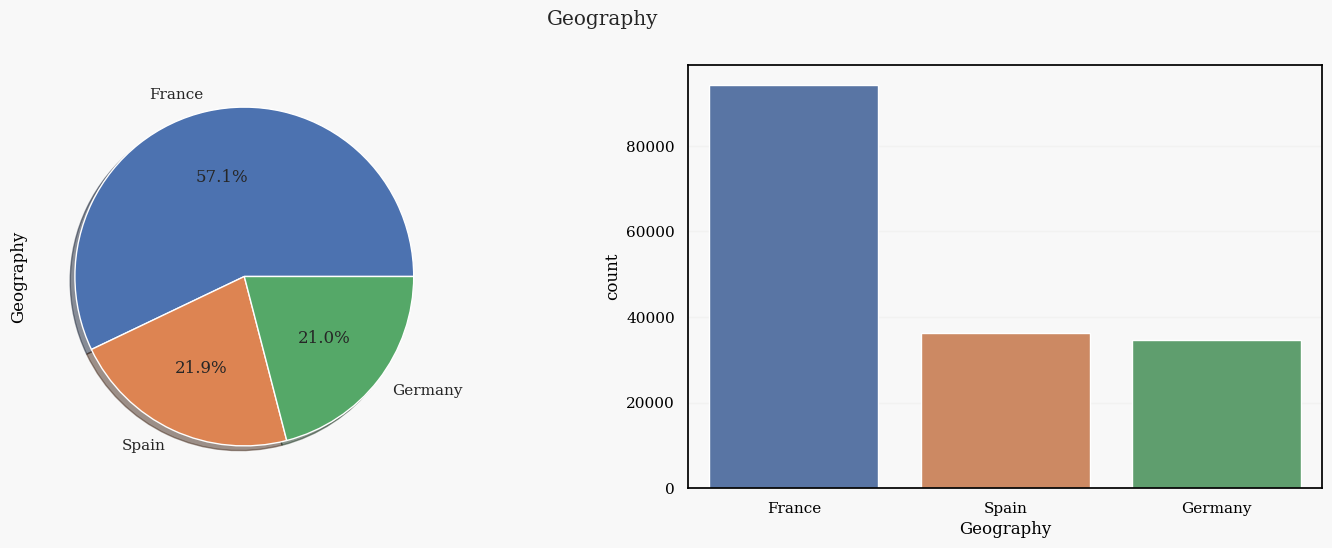

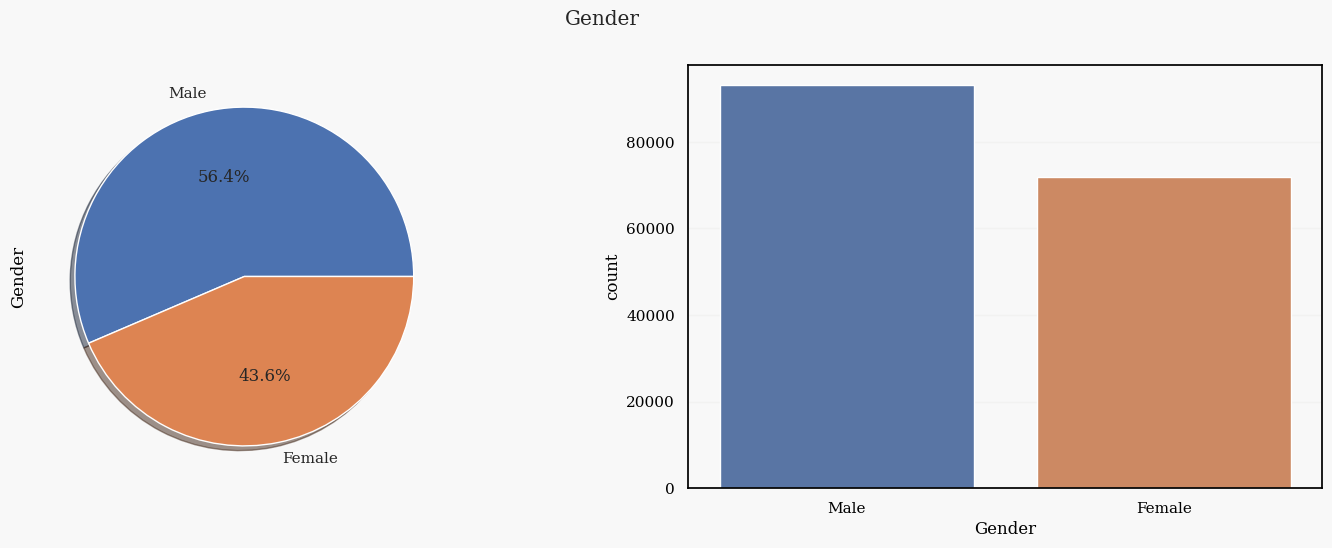

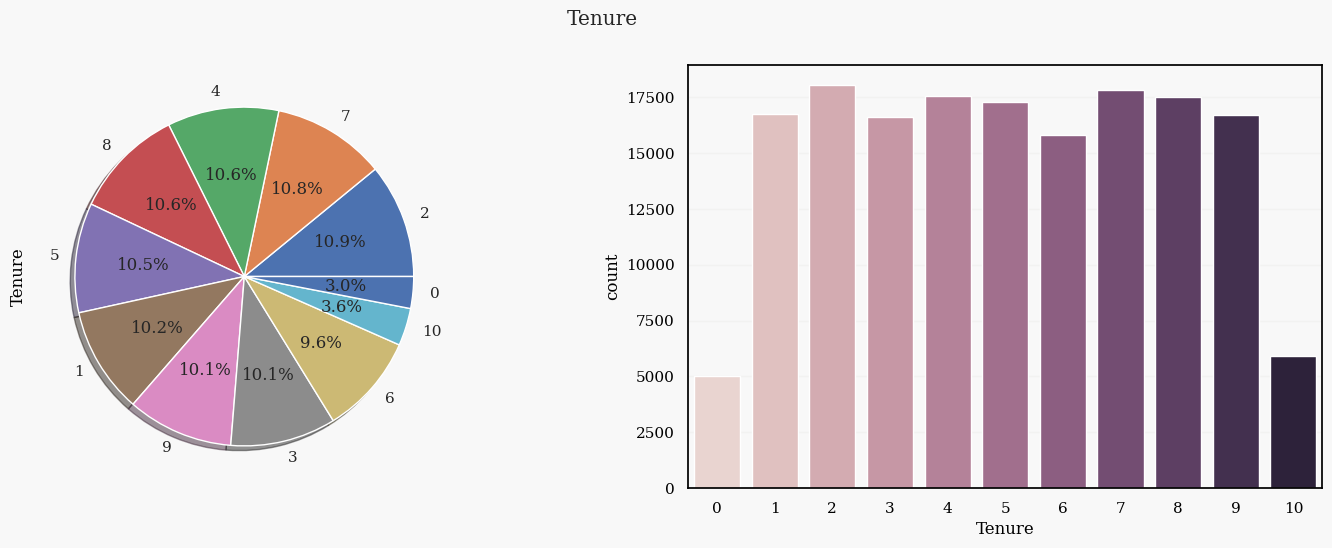

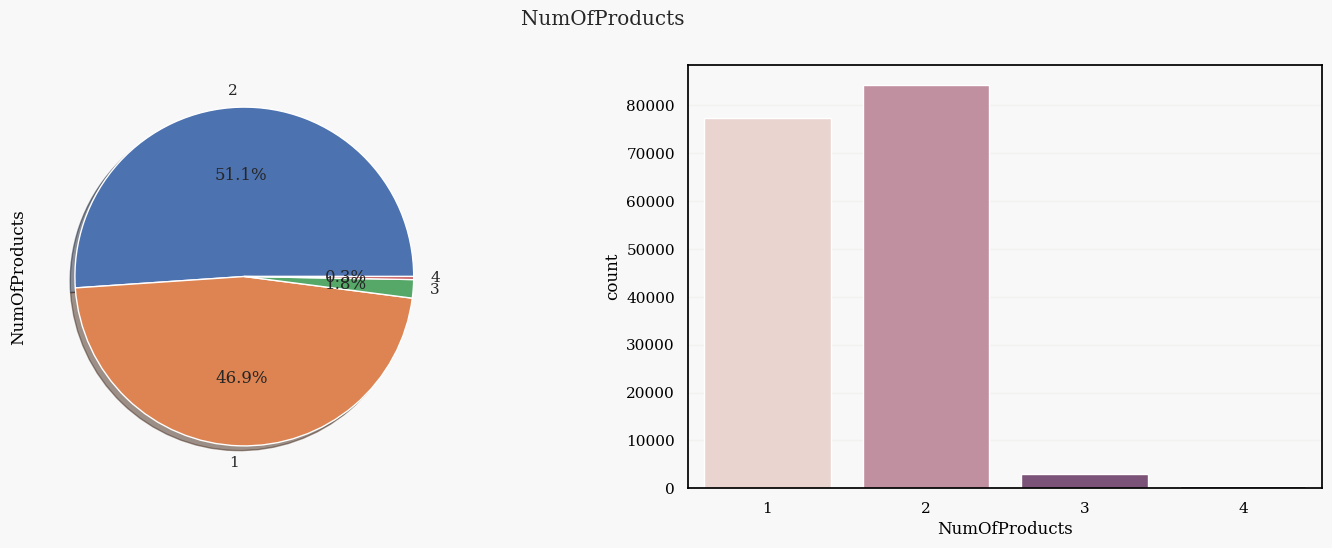

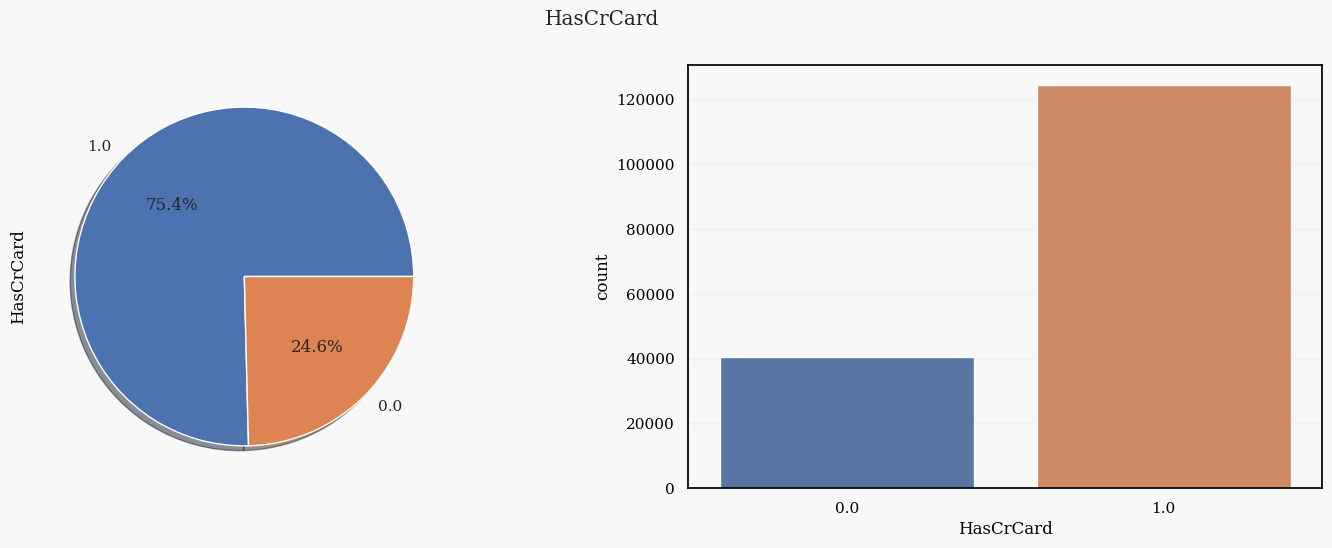

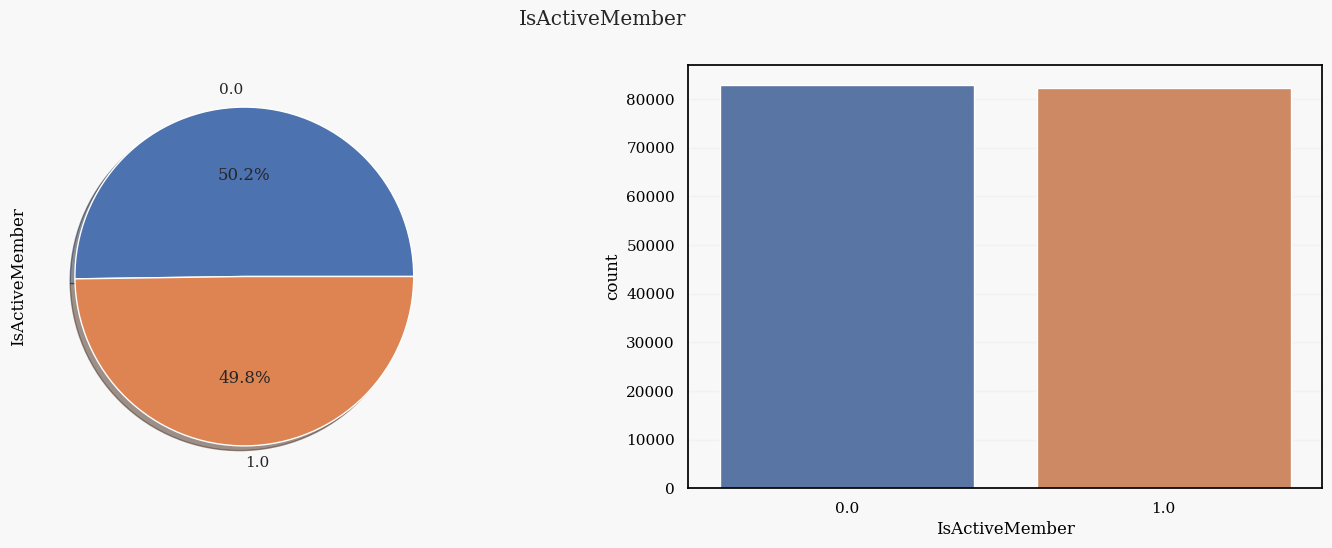

In [10]:
categorical_vars.remove('Exited') #목표변수이므로

for column in categorical_vars:
    f,ax=plt.subplots(1,2,figsize=(18,5.5))
    
    train_data[column].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True)
    ax[0].set_ylabel(f'{column}')
    
    sns.countplot(x =column, data=train_data, ax=ax[1], hue = column, legend =False)
    
    plt.suptitle(f'{column}')
    plt.show()

### 2.3 수치형 변수 분석(Numerical Variable)
- balance 변수의 데이터 대부분 0값으로 분포가 0으로 치우쳐져 있다.
- 다른 변수들도 분포에서 왜곡이 나타난다.
- 각 변수에 대한 데이터의 분포는 두 클래스 모두 거의 동일하다.

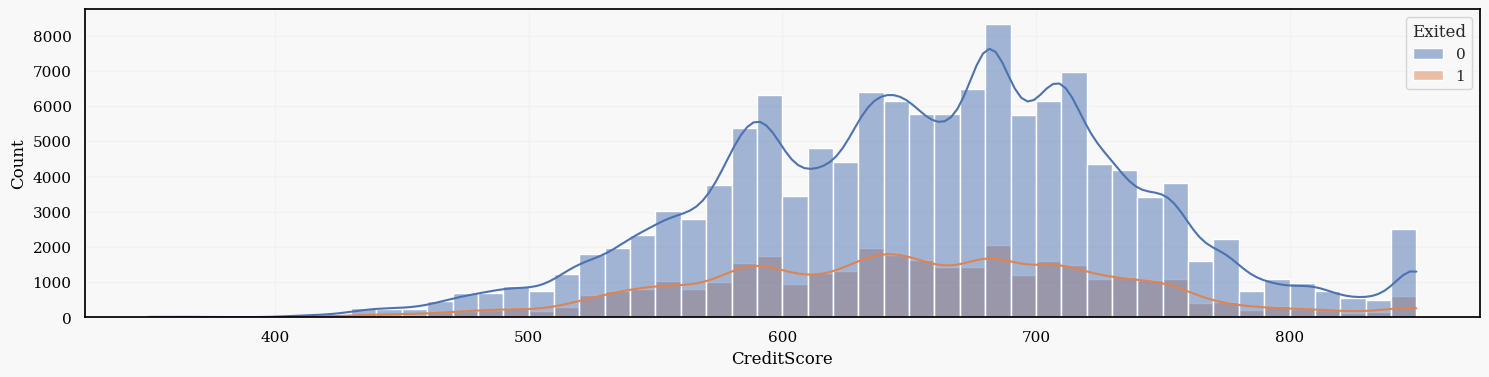

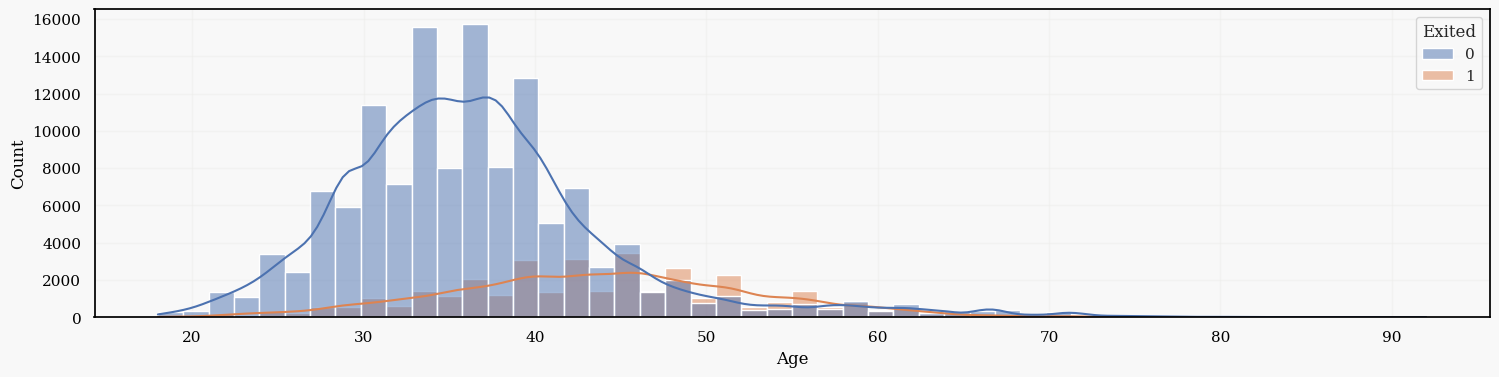

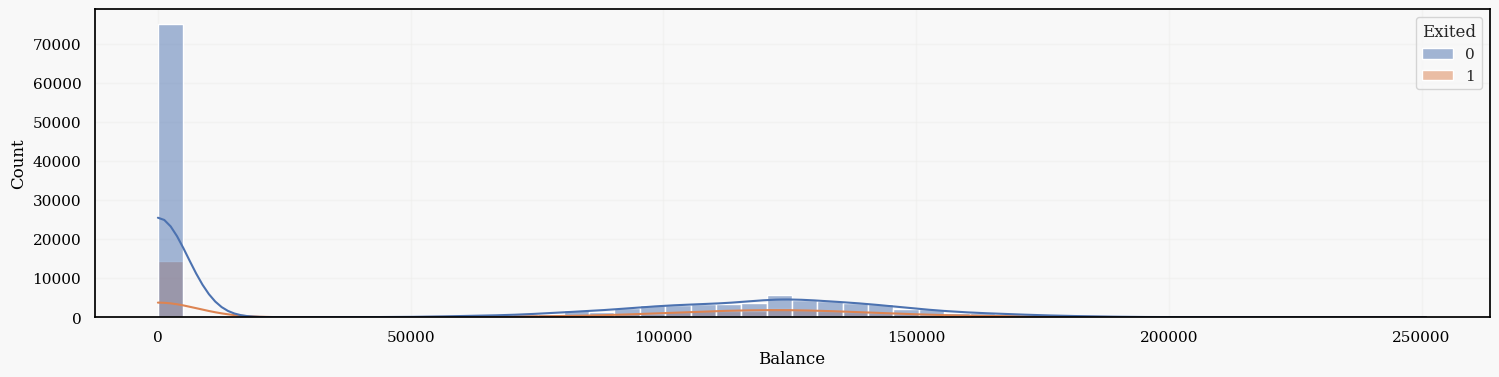

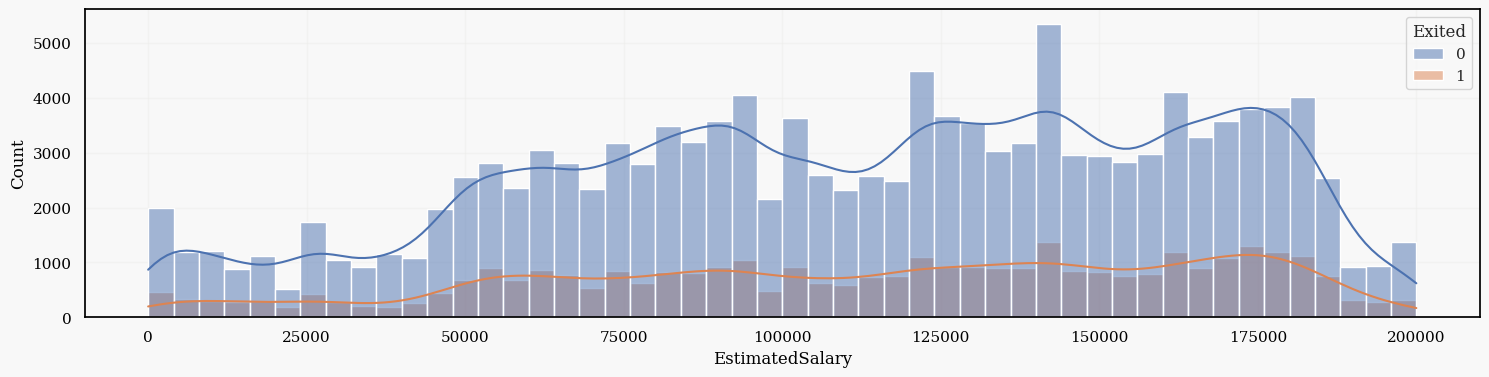

In [11]:
continuous_vars.remove('CustomerId')
continuous_vars.remove('Surname')

for column in continuous_vars:
    fig, ax = plt.subplots(figsize=(18, 4))
    
    fig = sns.histplot(data=train_data, x=column, hue="Exited", bins=50, kde=True) #막대 50개, KDE(커널 밀도 그래프) 추가
    
    plt.show()

### 2.4 다변량 분석(Multivariate)

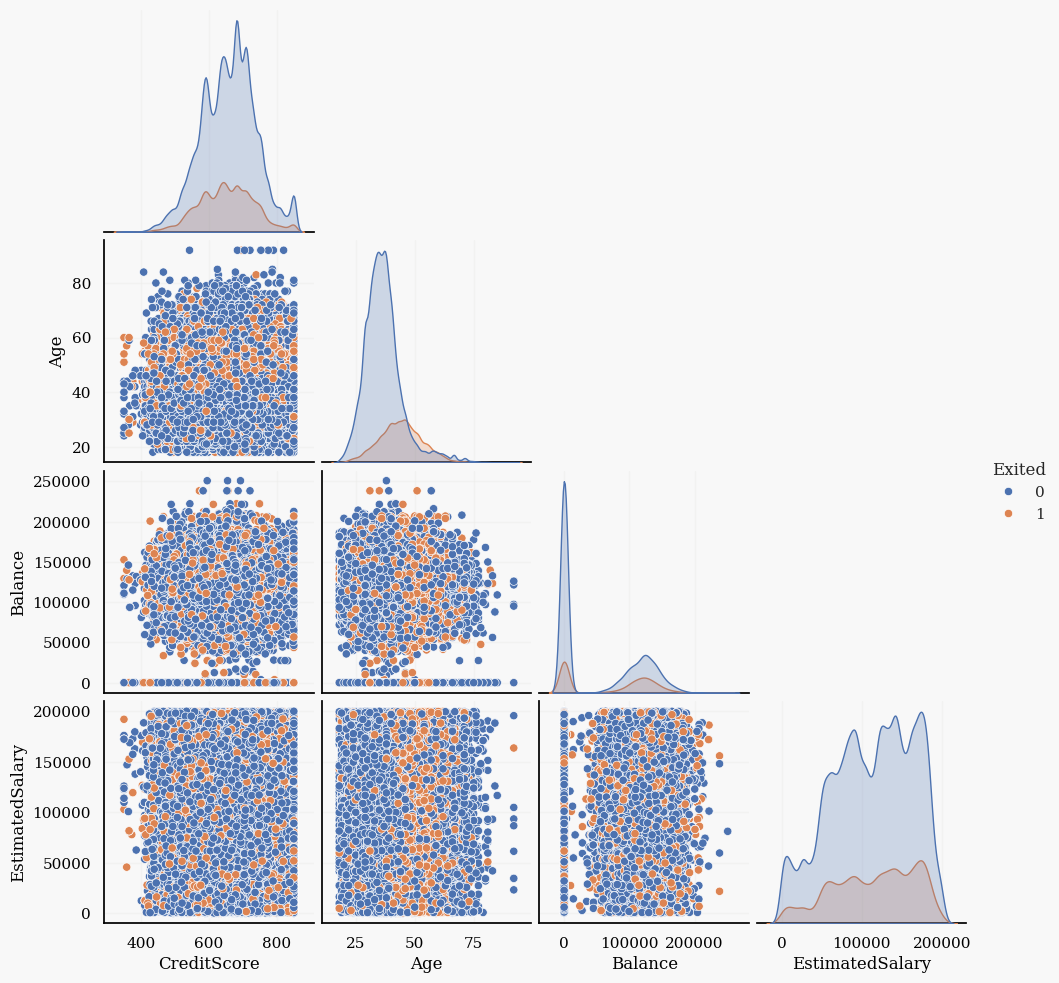

In [12]:
df3 = train_data[['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Exited']].copy()
sns.pairplot(df3, hue="Exited", corner=True)
plt.show()

### 2.5 상관 분석(Correlation)

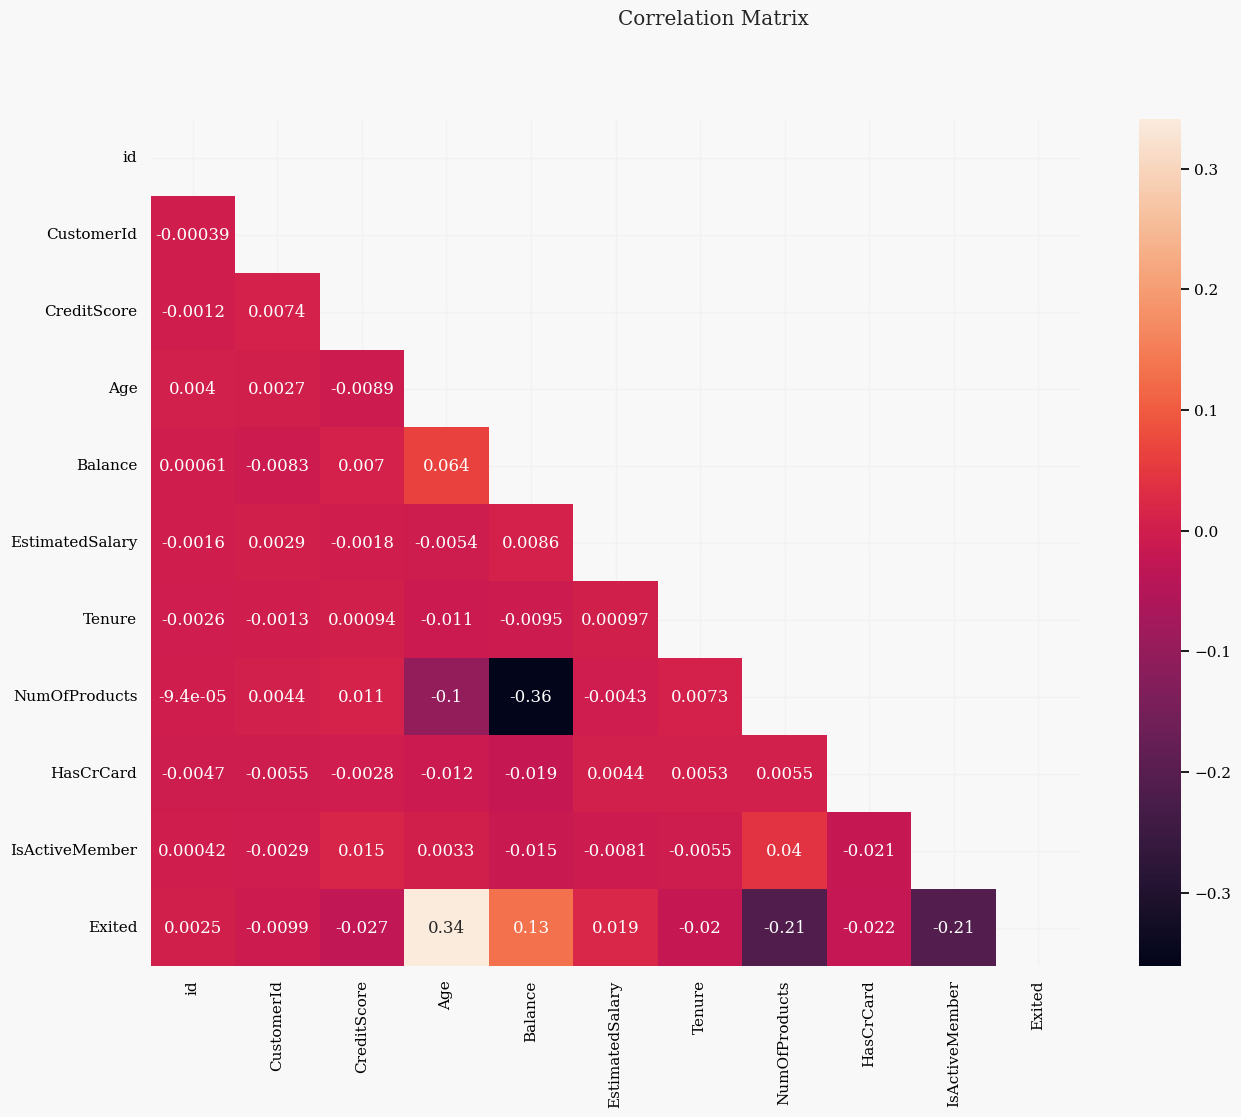

In [13]:
df4 = train_data[['id', 'CustomerId', 'CreditScore', 'Age', 'Balance', 'EstimatedSalary', 
       'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited']].copy()

corr_matrix=df4.corr()

mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True

f,ax=plt.subplots(figsize=(15,11))
sns.heatmap(corr_matrix, mask=mask, annot=True)
plt.suptitle('Correlation Matrix')
plt.savefig('그래프1.png')
plt.show()

### 3. 팀 프로젝트

In [14]:
import statsmodels as smf
from statsmodels.formula.api import ols

formula = 'Exited ~ Age'
result = ols(formula, data = train_data).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Exited   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                 2.168e+04
Date:                Wed, 17 Jan 2024   Prob (F-statistic):               0.00
Time:                        09:48:21   Log-Likelihood:                -76215.
No. Observations:              165034   AIC:                         1.524e+05
Df Residuals:                  165032   BIC:                         1.525e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3868      0.004    -92.709      0.000      -0.395      -0.379
Age            0.0157      0.000    147.247      0.000       0.015       0.016
==============================================================================
Omnibus:                    24484.297   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            37343.566
Skew:                           1.162   Prob(JB):                         0.00
Kurtosis:                       3.171   Cond. No.                         173.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
formula = "Exited ~ Age + Balance + NumOfProducts + IsActiveMember"
model = ols(formula, data = train_data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Exited   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     9844.
Date:                Wed, 17 Jan 2024   Prob (F-statistic):               0.00
Time:                        09:48:21   Log-Likelihood:                -68743.
No. Observations:              165034   AIC:                         1.375e+05
Df Residuals:                  165029   BIC:                         1.375e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.1089      0.005    -20.451      0.000      -0.119      -0.098
Age                0.0148      0.000    144.909      0.000       0.015       0.015
Balance         3.237e-07   1.54e-08     20.980      0.000    2.93e-07    3.54e-07
NumOfProducts     -0.1161      0.002    -65.287      0.000      -0.120      -0.113
IsActiveMember    -0.1670      0.002    -92.326      0.000      -0.170      -0.163
==============================================================================
Omnibus:                    21106.829   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            30366.570
Skew:                           1.046   Prob(JB):                         0.00
Kurtosis:                       3.209   Cond. No.                     5.06e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.06e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [16]:
target_data = train_data.copy()
from sklearn.preprocessing import StandardScaler

std=StandardScaler()
std.fit(target_data[['Balance']])
target_data[['Balance']] = std.transform(target_data[['Balance']])
target_data.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,-0.883163,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,-0.883163,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,-0.883163,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,1.486918,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,-0.883163,2,1.0,1.0,15068.83,0


In [17]:
formula = "Exited  ~ Age  +Balance+ NumOfProducts + IsActiveMember"
model2 = ols(formula, data = target_data).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Exited   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     9844.
Date:                Wed, 17 Jan 2024   Prob (F-statistic):               0.00
Time:                        09:48:21   Log-Likelihood:                -68743.
No. Observations:              165034   AIC:                         1.375e+05
Df Residuals:                  165029   BIC:                         1.375e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.0909      0.005    -17.791      0.000      -0.101      -0.081
Age                0.0148      0.000    144.909      0.000       0.015       0.015
Balance            0.0203      0.001     20.980      0.000       0.018       0.022
NumOfProducts     -0.1161      0.002    -65.287      0.000      -0.120      -0.113
IsActiveMember    -0.1670      0.002    -92.326      0.000      -0.170      -0.163
==============================================================================
Omnibus:                    21106.829   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            30366.570
Skew:                           1.046   Prob(JB):                         0.00
Kurtosis:                       3.209   Cond. No.                         227.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

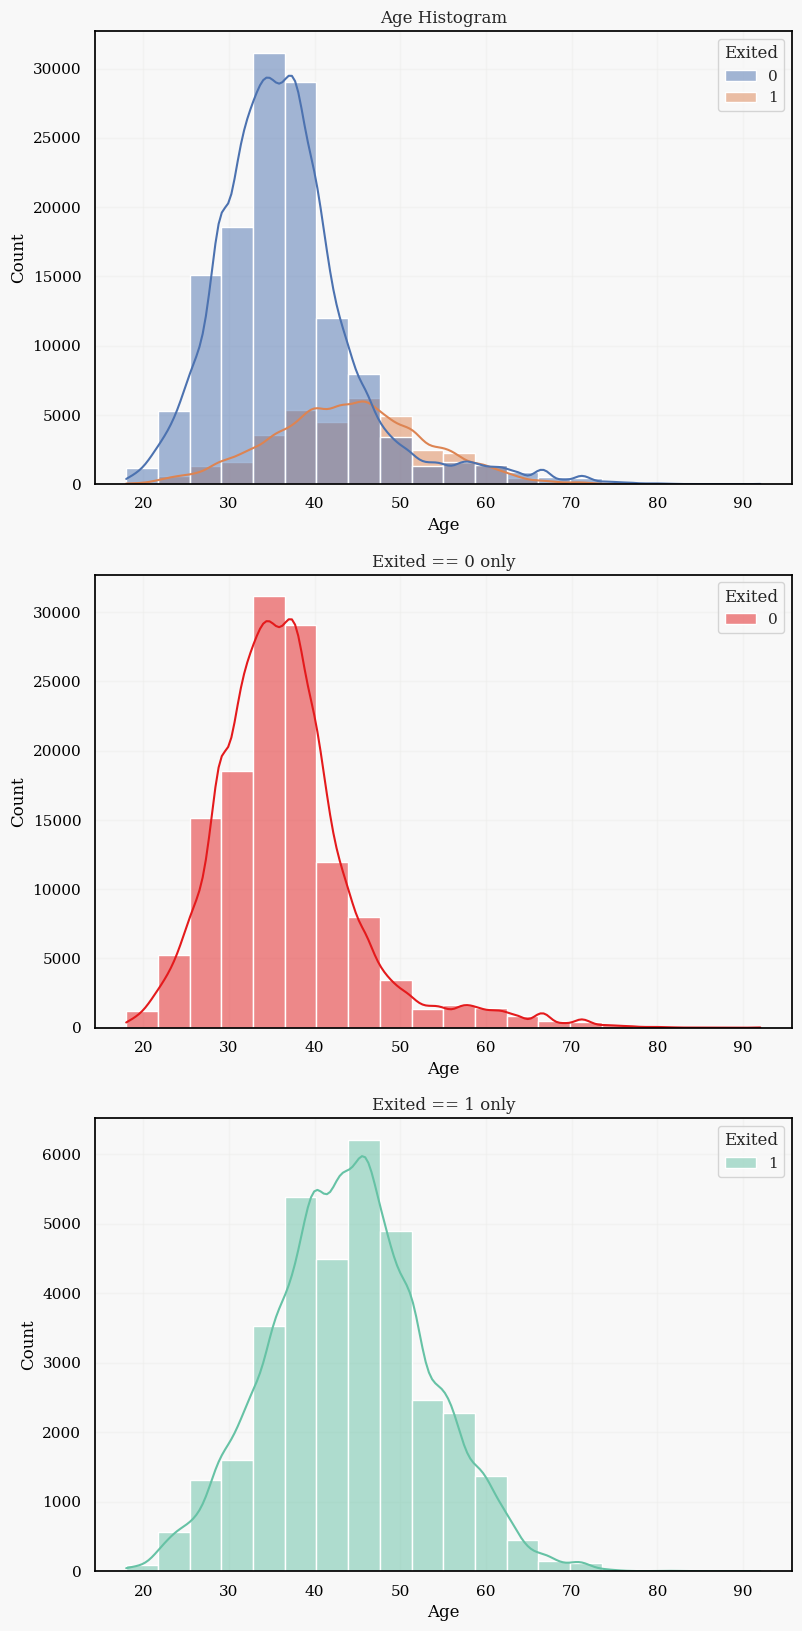

In [18]:
fig, ax = plt.subplots(3, 1, figsize = (9, 20))

sns.histplot(data=train_data, x='Age', hue="Exited", bins=20, kde=True, ax = ax[0])
ax[0].set_title('Age Histogram')

sns.histplot(data=train_data.loc[train_data["Exited"] == 0], x='Age', hue="Exited", bins=20, kde=True, ax = ax[1], palette = 'Set1')
ax[1].set_title('Exited == 0 only')

sns.histplot(data=train_data.loc[train_data["Exited"] == 1], x='Age', hue="Exited", bins=20, kde=True, ax = ax[2], palette = 'Set2')
ax[2].set_title('Exited == 1 only')

plt.savefig('그래프2.png')
plt.show()

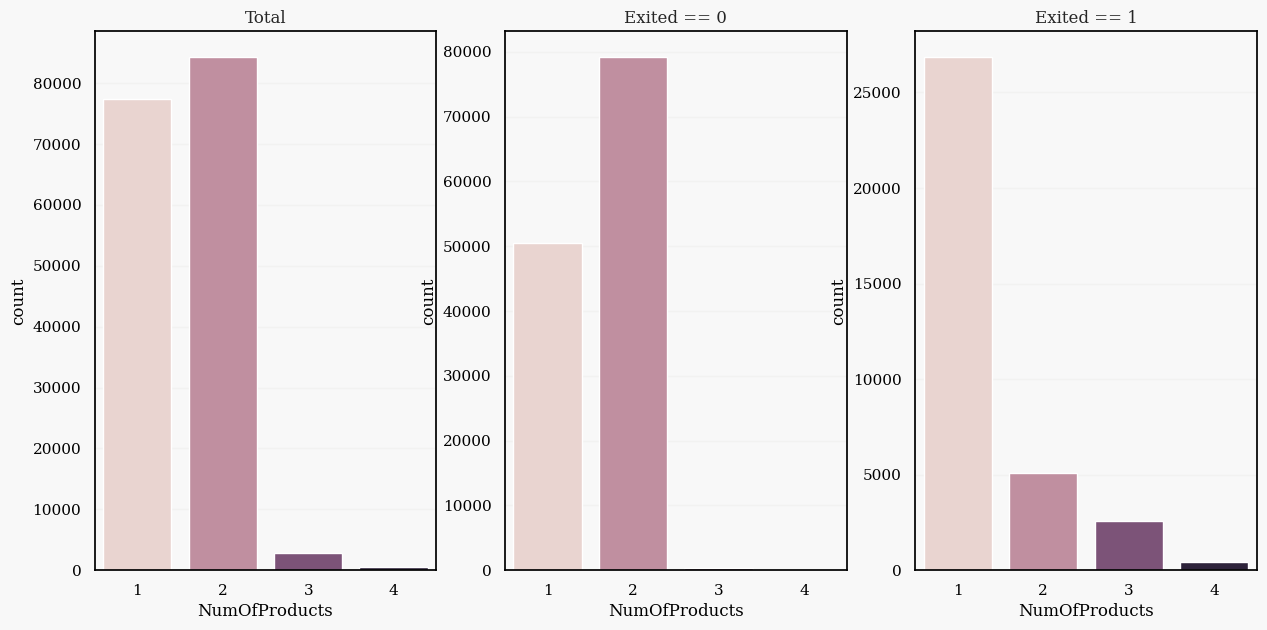

In [19]:
f, ax = plt.subplots(1, 3, figsize=(15, 7))

sns.countplot(x='NumOfProducts', data=train_data, ax = ax[0], hue = 'NumOfProducts', legend =False)
ax[0].set_title('Total')

sns.countplot(x='NumOfProducts', data=train_data.loc[train_data["Exited"] == 0], ax = ax[1], hue = 'NumOfProducts', legend =False)
ax[1].set_title('Exited == 0')

sns.countplot(x='NumOfProducts', data=train_data.loc[train_data["Exited"] == 1], ax = ax[2], hue = 'NumOfProducts', legend =False)
ax[2].set_title('Exited == 1')

plt.savefig('그래프3.png')
plt.show()

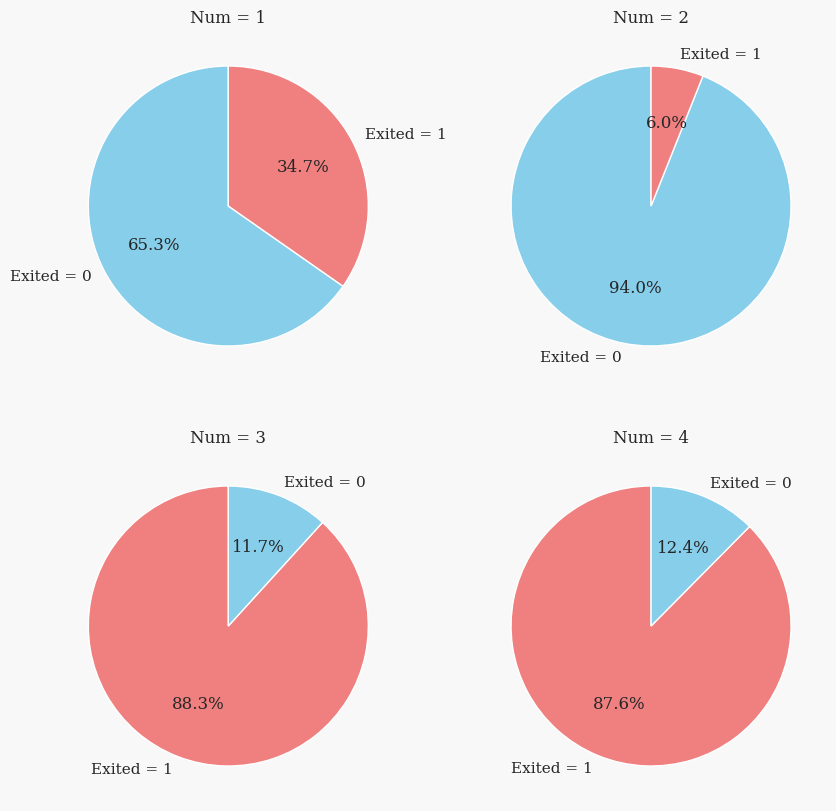

In [20]:
#Num이 i인 고객들의 Exited 비율 계산
#i in range(1, 4)
subset_data1 = train_data[train_data['NumOfProducts'] == 1]['Exited'].value_counts().rename({0: 'Exited = 0', 1: 'Exited = 1'})
subset_data2 = train_data[train_data['NumOfProducts'] == 2]['Exited'].value_counts().rename({0: 'Exited = 0', 1: 'Exited = 1'})
subset_data3 = train_data[train_data['NumOfProducts'] == 3]['Exited'].value_counts().rename({0: 'Exited = 0', 1: 'Exited = 1'})
subset_data4 = train_data[train_data['NumOfProducts'] == 4]['Exited'].value_counts().rename({0: 'Exited = 0', 1: 'Exited = 1'})

# 파이 차트 그리기
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

# 'Exited'가 0인 값의 파이 차트
ax[0, 0].pie(subset_data1, labels=subset_data1.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral'])
ax[0, 0].set_title('Num = 1')

ax[0, 1].pie(subset_data2, labels=subset_data2.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral'])
ax[0, 1].set_title('Num = 2')

ax[1, 0].pie(subset_data3, labels=subset_data3.index, autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'skyblue'])
ax[1, 0].set_title('Num = 3')

ax[1, 1].pie(subset_data4, labels=subset_data4.index, autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'skyblue'])
ax[1, 1].set_title('Num = 4')

plt.savefig('그래프4.png')
# 그래프 출력
plt.show()

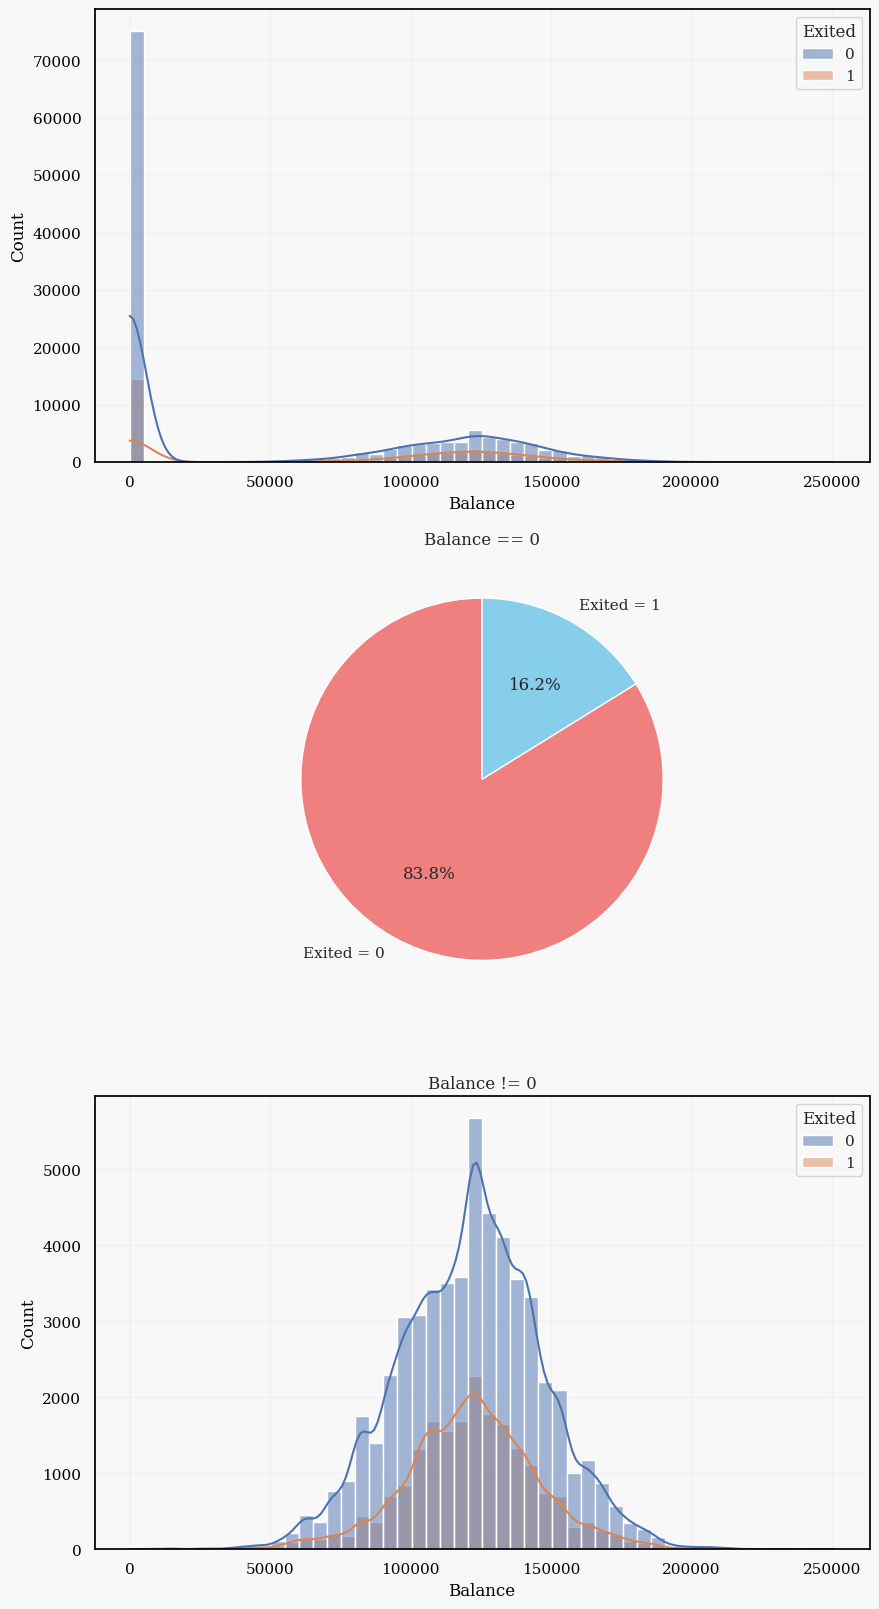

In [21]:
f,ax=plt.subplots(3,1,figsize=(10,20))

sns.histplot(data=train_data, x='Balance', hue="Exited", bins=50, kde=True, ax = ax[0])

subset_data1 = train_data[train_data['Balance'] == 0]['Exited'].value_counts().rename({0: 'Exited = 0', 1: 'Exited = 1'})
ax[1].pie(subset_data1, labels=subset_data1.index, autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'skyblue'])
ax[1].set_title('Balance == 0')

subset_data2 = train_data[train_data['Balance'] != 0]
sns.histplot(data=subset_data2, x='Balance', hue="Exited", bins=50, kde = True, ax = ax[2])
ax[2].set_title('Balance != 0')

plt.savefig('그래프5.png')
plt.show()

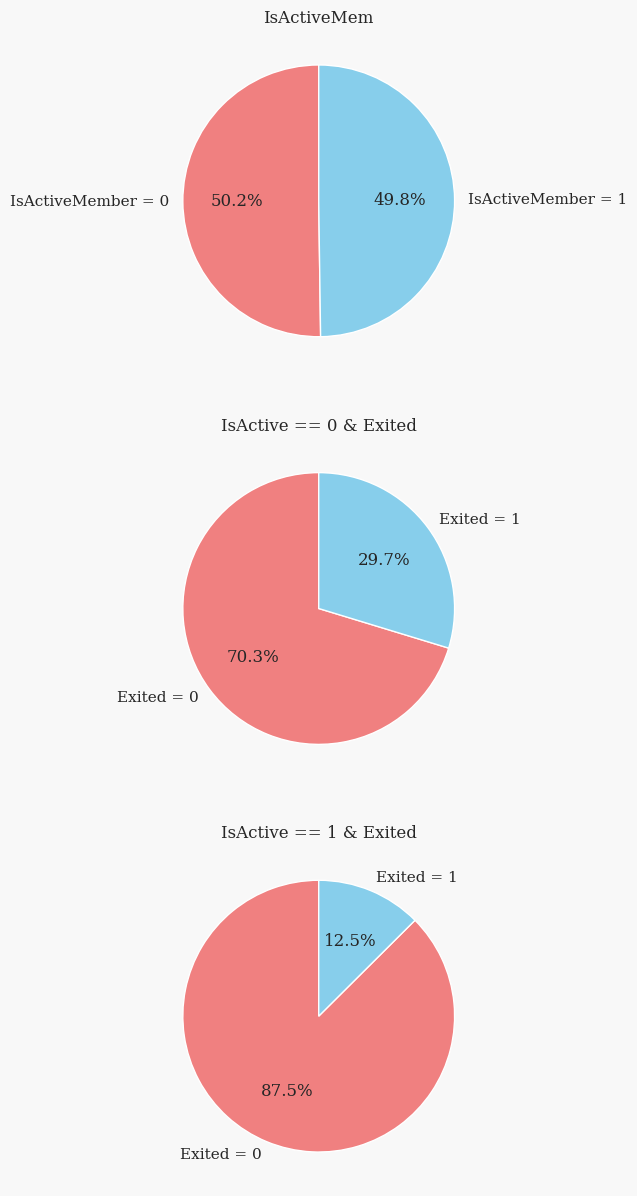

In [52]:
fig, ax = plt.subplots(3, 1, figsize=(8,15))

subset_data = train_data['IsActiveMember'].value_counts().rename({0: 'IsActiveMember = 0', 1: 'IsActiveMember = 1'})
ax[0].pie(subset_data, labels=subset_data.index, autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'skyblue'])
ax[0].set_title('IsActiveMem')

subset_data1 = train_data[train_data['IsActiveMember'] == 0]['Exited'].value_counts().rename({0: 'Exited = 0', 1: 'Exited = 1'})
ax[1].pie(subset_data1, labels=subset_data1.index, autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'skyblue'])
ax[1].set_title('IsActive == 0 & Exited')

subset_data2 = train_data[train_data['IsActiveMember'] == 1]['Exited'].value_counts().rename({0: 'Exited = 0', 1: 'Exited = 1'})
ax[2].pie(subset_data2, labels=subset_data2.index, autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'skyblue'])
ax[2].set_title('IsActive == 1 & Exited')

plt.savefig('그래프6.png')
plt.show()

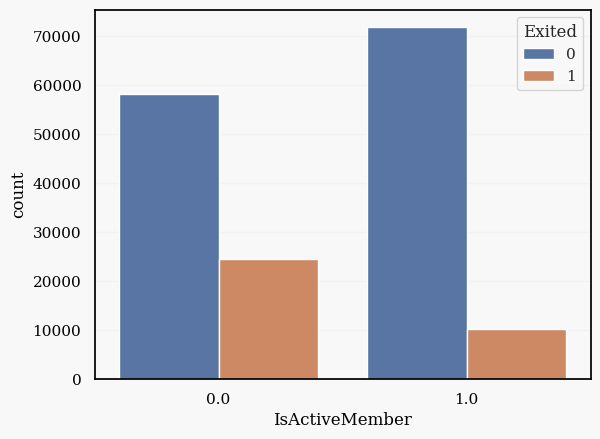

In [60]:
sns.countplot(data = train_data, x = 'IsActiveMember', hue = 'Exited')

plt.show()

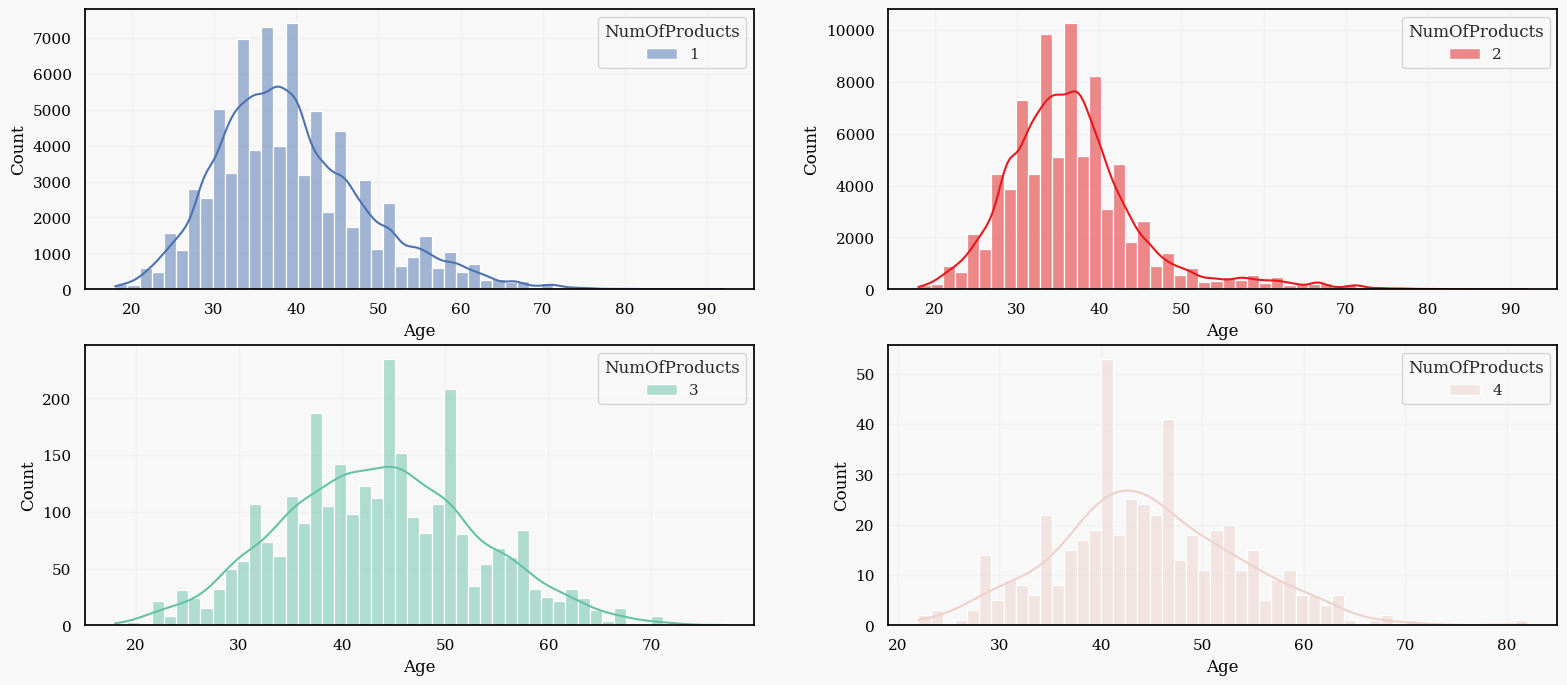

In [57]:
f,ax=plt.subplots(2,2,figsize=(19,8))
subset_data1 = train_data[train_data['NumOfProducts'] == 1]
subset_data2 = train_data[train_data['NumOfProducts'] == 2]
subset_data3 = train_data[train_data['NumOfProducts'] == 3]
subset_data4 = train_data[train_data['NumOfProducts'] == 4]

sns.histplot(data=subset_data1, x='Age', hue="NumOfProducts", bins=50, kde=True, ax = ax[0, 0])
sns.histplot(data=subset_data2, x='Age', hue="NumOfProducts", bins=50, kde=True, ax = ax[0, 1], palette = 'Set1')
sns.histplot(data=subset_data3, x='Age', hue="NumOfProducts", bins=50, kde=True, ax = ax[1, 0], palette = 'Set2')
sns.histplot(data=subset_data4, x='Age', hue="NumOfProducts", bins=50, kde=True, ax = ax[1, 1])

plt.show()

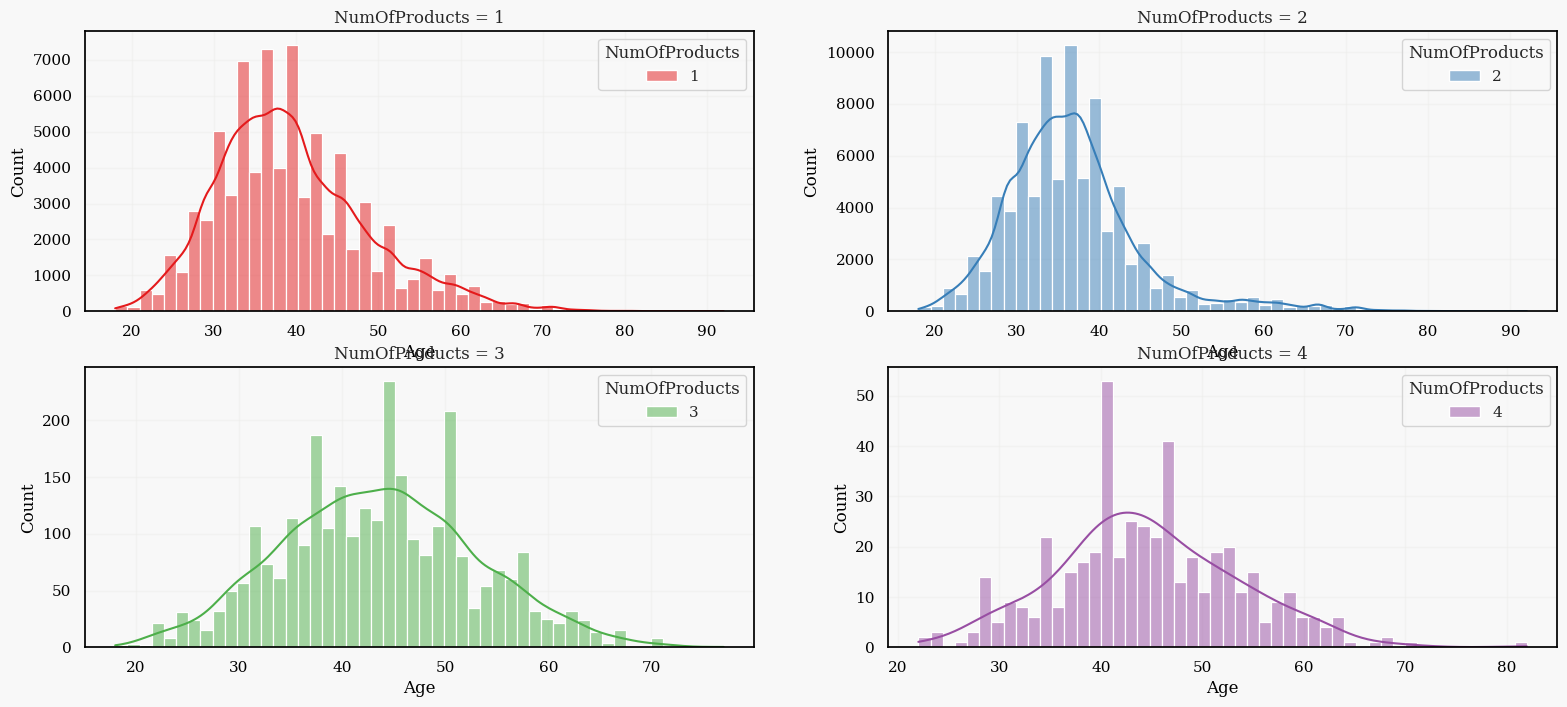

In [59]:
#clean code prompt를 돌린 결과

fig, ax = plt.subplots(2, 2, figsize=(19, 8))
colors = sns.color_palette('Set1', n_colors=4)

for num_products, subplot, color in zip(range(1, 5), ax.flatten(), colors):
    subset_data = train_data[train_data['NumOfProducts'] == num_products]
    sns.histplot(data=subset_data, x='Age', hue='NumOfProducts', bins=50, kde=True, ax=subplot, palette={num_products: color})
    subplot.set_title(f'NumOfProducts = {num_products}')

plt.show()

In [61]:
train_data_bal=train_data.copy()

train_data_bal['balance_zero'] = train_data_bal['Balance'].apply(lambda x : 1 if x == 0 else 0)

train_data_bal.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,balance_zero
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,1
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,1
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,1
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,1


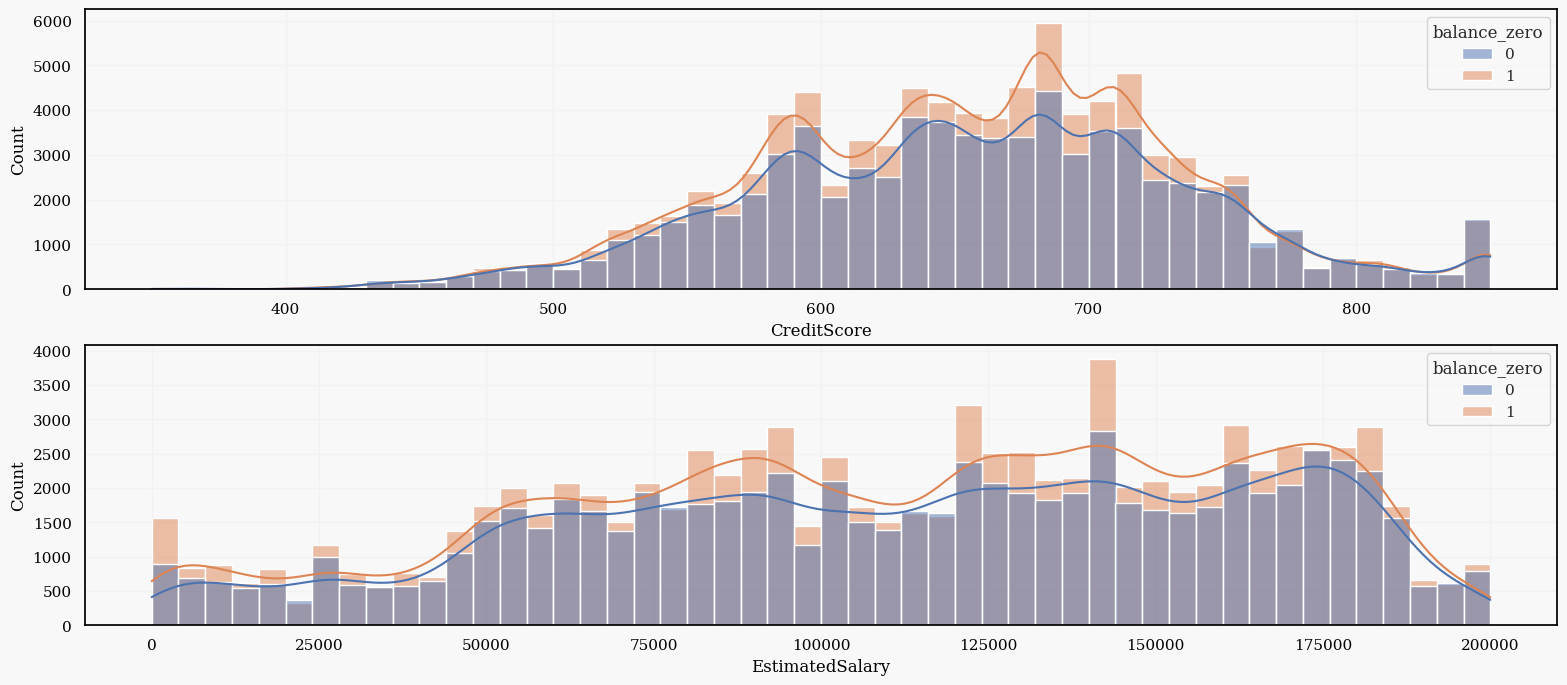

In [62]:
f,ax=plt.subplots(2,1,figsize=(19,8))

sns.histplot(data=train_data_bal, x='CreditScore', hue="balance_zero", bins=50, kde = True, ax = ax[0])
sns.histplot(data=train_data_bal, x='EstimatedSalary', hue="balance_zero", bins=50, kde = True, ax = ax[1])

plt.show()

### 3. 모델링

### 3.1 데이터 준비

In [ ]:
X = train_data.drop(['id', 'CustomerId', 'Surname'], axis=1) #클래스에 대한 유의미한 정보를 지니고 있지 않는 column들 삭제

In [ ]:
X.head()

### 3.1 데이터 인코딩
- 범주형 데이터를 모델이 인식할 수 있도록 하는 일련의 변환 과정
1. Label Encoding
    + 알파벳 순서에 따라 문자형 데이터를 unique한 숫자형 데이터로 매핑하는 기법
    + 변수가 순서, 랭크의 의미가 있을 때, 고유값의 개수가 많을 때 효율적임
    + 단점: 알파벳 순서로 숫자가 부여되어서 모델에 랭크로 잘못 반영될 위험이 있음 (country인데 랭크가 부여되는 등)
2. One-Hot Encoding
    + 각 카테고리를 0과 1로 구성된 벡터로 표현하는 기법
    + 각 카테고리가 새로운 변수가 되어 표현됨, 중요도를 없앨 수 있음
    + 변수 간 순서의 의미가 없을 때, 고유값의 개수가 많지 않을 때 효율적임
    + 단점: 다중공선성을 일으킬 위험이 있음

In [ ]:
#Label Encoding: pd.factorize()

X = train_data.drop(['id', 'CustomerId', 'Surname'], axis=1) #클래스에 대한 유의미한 정보를 지니고 있지 않는 column들 삭제

for column in ['Geography', 'Gender', 'IsActiveMember', 'HasCrCard', 'NumOfProducts']:
    X.loc[:, f'{column}_Factorize'] = pd.factorize(X[column])[0].reshape(-1, 1)
    #[0]: 튜플 중 첫번재를 반환. 
    #(-1, 1): 2차월 배열. -1(해당 차원의 크기 자동 조정), 1(열의 크기)

X = X.drop(['Geography', 'Gender', 'IsActiveMember', 'IsActiveMember', 'HasCrCard', 'NumOfProducts'], axis = 1)
X.head()

In [ ]:
#One-Hot Encoding: pd.get_dummies()

X = train_data.drop(['id', 'CustomerId', 'Surname'], axis=1) #클래스에 대한 유의미한 정보를 지니고 있지 않는 column들 삭제

X = pd.get_dummies(X, columns =  ['Geography', 'Gender', 'IsActiveMember',
                                  'HasCrCard', 'NumOfProducts'],
                   dtype = 'int')
X.head()

- One-Hot 인코딩으로 진행

In [ ]:
X.describe().T

In [ ]:
df4 = X.copy()

corr_matrix=df4.corr()

mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True

f,ax=plt.subplots(figsize=(20,11))
sns.heatmap(corr_matrix, mask=mask, annot=True)
plt.suptitle('Correlation Matrix')
plt.show()